In [2]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "src"))


In [3]:
from load_data import load_nifty, load_indiavix, load_usd_inr

nifty = load_nifty()
vix = load_indiavix()
usd_inr = load_usd_inr()

print(nifty.head())
print(vix.head())
print(usd_inr.head())

        Date  NIFTY_Close
0 2000-01-03       1592.2
1 2000-01-04       1638.7
2 2000-01-05       1595.8
3 2000-01-06       1617.6
4 2000-01-07       1613.3
        Date  India_VIX
0 2025-01-01    14.5075
1 2025-01-02    13.7375
2 2025-01-03    13.5400
3 2025-01-06    15.6500
4 2025-01-07    14.6600
        Date    USD_INR
0 2025-01-02  85.785698
1 2025-01-03  85.804001
2 2025-01-06  85.759003
3 2025-01-07  85.680702
4 2025-01-08  85.806503


c:\Users\hp\OneDrive\Desktop\QUANT GLOBAL ASSIGNMENT\load_data.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [4]:
# Set Date as index
nifty_m = nifty.set_index("Date").resample("ME").last().reset_index()
# Compute monthly returns
nifty_m["NIFTY_Return"] = nifty_m["NIFTY_Close"].pct_change()

In [5]:
#India VIX: Monthly Average
vix_m = vix.set_index("Date").resample("ME").mean().reset_index()

#USD/INR: Month-end Exchange Rate
usd_m = usd_inr.set_index("Date").resample("ME").last().reset_index()

In [6]:
#Restrict to 2025 (Safety Check)
start_date = "2025-01-01"
end_date = "2025-12-31"

nifty_m = nifty_m[(nifty_m["Date"] >= start_date) & (nifty_m["Date"] <= end_date)]
vix_m   = vix_m[(vix_m["Date"] >= start_date) & (vix_m["Date"] <= end_date)]
usd_m   = usd_m[(usd_m["Date"] >= start_date) & (usd_m["Date"] <= end_date)]

In [7]:
#Merge All Datasets

final_df = (
    nifty_m[["Date", "NIFTY_Return"]]
    .merge(vix_m[["Date", "India_VIX"]], on="Date", how="inner")
    .merge(usd_m[["Date", "USD_INR"]], on="Date", how="inner")
)

# Drop first row (NaN return from pct_change)
final_df.dropna(inplace=True)

print(final_df)

        Date  NIFTY_Return  India_VIX    USD_INR
0 2025-01-31     -0.005769  15.928587  86.647003
1 2025-02-28     -0.058860  14.499375  87.327003
2 2025-03-31      0.063036  13.443684  85.538803
3 2025-04-30      0.034646  16.828947  85.170799
4 2025-05-31      0.027408  18.022857  85.361298


In [8]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [9]:
#Prepare Target and Features

# Target variable (monthly NIFTY returns)
y = final_df["NIFTY_Return"].values

# Feature matrix (factors)
X = final_df[["India_VIX", "USD_INR"]].values

In [10]:
#Standardize the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
#the Regression Model
model = Ridge(alpha=1.0)
model.fit(X_scaled, y)

Ridge()

In [12]:
#Extract And Interpret the coefficients
coefficients = {
    "India_VIX": model.coef_[0],
    "USD_INR": model.coef_[1],
    "Intercept": model.intercept_
}

print("Model Coefficients:")
print(coefficients)

Model Coefficients:
{'India_VIX': np.float64(-0.009229808119421994), 'USD_INR': np.float64(-0.034667921585246626), 'Intercept': np.float64(0.012092245864525182)}


In [21]:
#Model Diagnostics
r_squared = model.score(X_scaled, y)
print(f"R-squared: {r_squared:.4f}")

R-squared: 0.8834


In [ ]:
#Residual Analysis
y_pred = model.predict(X_scaled)
residuals = y - y_pred
print("Residual Mean:", residuals.mean())
print("Residual Std Dev:", residuals.std())



Residual Mean: 6.938893903907229e-19
Residual Std Dev: 0.014234188769711845


In [ ]:
#Mean Squared Error (MSE) & RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, y_pred)
rmse = mse ** 0.5
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")


MSE: 0.000203
RMSE: 0.014234


In [ ]:
#Correlation Between Actual & Predicted Returns
corr = np.corrcoef(y, y_pred)[0, 1]
print(f"Correlation (Actual vs Predicted): {corr:.4f}")


Correlation (Actual vs Predicted): 0.9596


In [14]:
#Now each return is explained additively by factors.
contributions = X_scaled * model.coef_

final_df["VIX_Contribution"] = contributions[:, 0]
final_df["USDINR_Contribution"] = contributions[:, 1]
final_df["Model_Predicted_Return"] = (
    final_df["VIX_Contribution"] +
    final_df["USDINR_Contribution"] +
    model.intercept_
)

In [15]:
#Which factor explained most of the index movement in 2025

total_contribution = {
    "India_VIX": final_df["VIX_Contribution"].sum(),
    "USD_INR": final_df["USDINR_Contribution"].sum(),
    "Intercept": model.intercept_ * len(final_df)
}

print("Total Factor Contribution:")
print(total_contribution)

Total Factor Contribution:
{'India_VIX': np.float64(3.8163916471489756e-17), 'USD_INR': np.float64(-1.1900203045200897e-15), 'Intercept': np.float64(0.06046122932262591)}


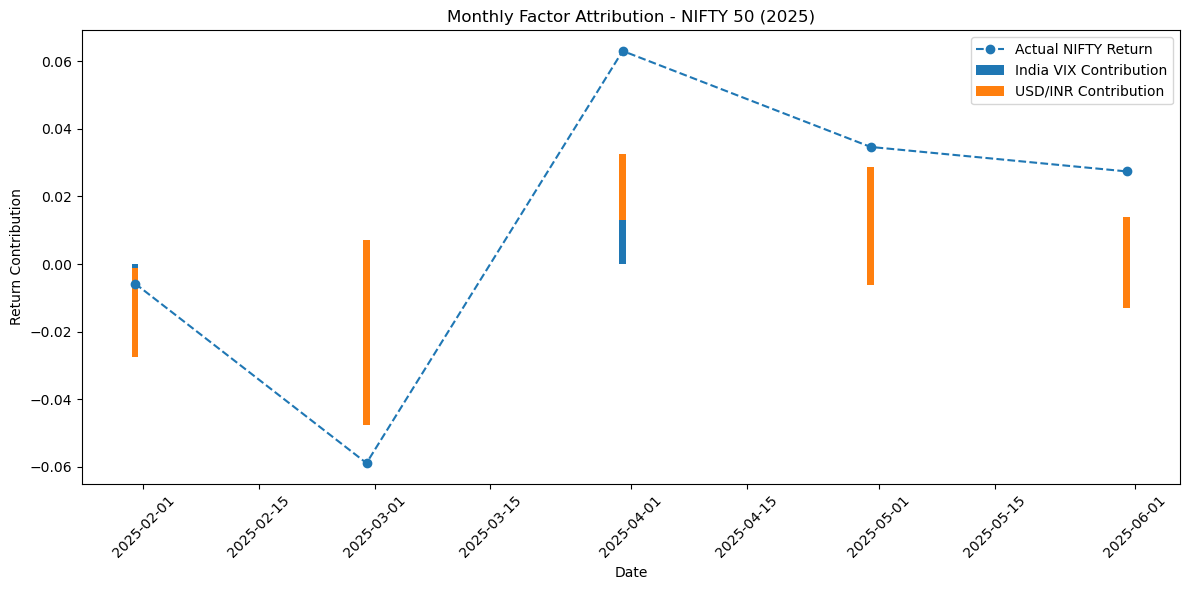

In [ ]:
#Visualization of Factor Contributions
# Set Date as index for plotting
import matplotlib.pyplot as plt
plot_df = final_df.set_index("Date")

# Create stacked bar plot
plt.figure(figsize=(12, 6))

plt.bar(
    plot_df.index,
    plot_df["VIX_Contribution"],
    label="India VIX Contribution"
)

plt.bar(
    plot_df.index,
    plot_df["USDINR_Contribution"],
    bottom=plot_df["VIX_Contribution"],
    label="USD/INR Contribution"
)

# Actual returns as line
plt.plot(
    plot_df.index,
    plot_df["NIFTY_Return"],
    linestyle="--",
    marker="o",
    label="Actual NIFTY Return"
)

plt.title("Monthly Factor Attribution - NIFTY 50 (2025)")
plt.xlabel("Date")
plt.ylabel("Return Contribution")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()